# 🚀 Entrenamiento YOLOv8 en Google Colab - V1 (Optimizado)

Este notebook entrena un modelo YOLOv8 con Ultralytics en Google Colab para detección de vida silvestre aérea.

## 🔥 **MEJORAS V1:**
- ✅ **Guardado automático en Drive** cada X épocas
- ✅ **Recuperación de entrenamiento** interrumpido
- ✅ **Configuración optimizada** para velocidad
- ✅ **Monitoreo en tiempo real** del progreso
- ✅ **Backup automático** de checkpoints

## 📋 Características
- **Modelo**: YOLOv8s, YOLOv8m, YOLOv8l, YOLOv8x
- **Detección automática de GPU**
- **Conversión automática COCO a YOLO**
- **Visualización de resultados**
- **Exportación a ONNX/TorchScript**
- **Análisis de métricas detallado**

## 🎯 Clases de Animales
- Buffalo
- Elephant  
- Kob
- Alcelaphinae
- Warthog
- Waterbuck

## ⚙️ Configuración por Defecto
- **Modelo**: YOLOv8s (balanceado entre velocidad y precisión)
- **Tamaño de imagen**: 640x640
- **Épocas**: 100
- **Batch size**: 16
- **Optimizador**: AdamW
- **Mixed Precision**: Habilitado

## 🔬 Ventajas de YOLOv8
- **Rápido**: Entrenamiento e inferencia eficientes
- **Preciso**: Mejor rendimiento que versiones anteriores
- **Fácil de usar**: API simple de Ultralytics
- **Flexible**: Múltiples tamaños de modelo

## 🔧 Instalación de Dependencias

In [1]:
# Instalar dependencias
%pip install -q ultralytics pyyaml opencv-python pillow tqdm matplotlib seaborn pandas

# Verificar instalación
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.0 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
GPU: NVIDIA L4
GPU Memory: 23.8 GB


## 📦 Importar Librerías

In [2]:
# ============================================================
# VARIABLES GLOBALES PARA BACKUP AUTOMÁTICO
# ============================================================

# Variables globales para el sistema de backup
backup_thread_running = False
backup_thread = None

print("✅ Variables globales de backup inicializadas")


✅ Variables globales de backup inicializadas


In [3]:
import os
import sys
import yaml
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import shutil
import json
from tqdm import tqdm

from ultralytics import YOLO
from google.colab import files, drive
from IPython.display import Image as IPImage, display

# Configurar matplotlib
plt.style.use('default')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA L4
CUDA memory: 23.8 GB


## 📁 Configuración de Datos

In [4]:
# ============================================================
# CONFIGURACIÓN DE RUTAS PRINCIPALES (Unificado con HerdNet)
# ============================================================

# Definir la ruta base principal (ajustar según el entorno: Drive o local)
BASE_DIR = Path("/content/drive/MyDrive/aerial-wildlife-count")

# ============================================================
# RUTAS DE IMÁGENES Y ANOTACIONES (COCO JSON) - Igual que HerdNet
# ============================================================

# Rutas de los archivos de anotaciones en formato COCO
TRAIN_ANN_FILE = BASE_DIR / "data" / "coco" / "train" / "train_annotations.json"
VAL_ANN_FILE = BASE_DIR / "data" / "coco" / "val" / "val_annotations.json"
TEST_ANN_FILE = BASE_DIR / "data" / "coco" / "test" / "test_annotations.json"

# Rutas de las carpetas de imágenes correspondientes a cada conjunto
TRAIN_IMG_DIR = BASE_DIR / "data" / "images" / "train"
VAL_IMG_DIR = BASE_DIR / "data" / "images" / "val"
TEST_IMG_DIR = BASE_DIR / "data" / "images" / "test"

# ============================================================
# RUTAS ALTERNATIVAS (Fallback para compatibilidad)
# ============================================================

# Rutas alternativas si no existe la estructura estándar
TRAIN_ANN_FILE_ALT = BASE_DIR / "data" / "groundtruth" / "json" / "big_size" / "train_big_size_A_B_E_K_WH_WB.json"
VAL_ANN_FILE_ALT = BASE_DIR / "data" / "groundtruth" / "json" / "big_size" / "val_big_size_A_B_E_K_WH_WB.json"
TEST_ANN_FILE_ALT = BASE_DIR / "data" / "groundtruth" / "json" / "big_size" / "test_big_size_A_B_E_K_WH_WB.json"

# Rutas alternativas para imágenes
TRAIN_IMG_DIR_ALT = BASE_DIR / "data" / "train"
VAL_IMG_DIR_ALT = BASE_DIR / "data" / "val"
TEST_IMG_DIR_ALT = BASE_DIR / "data" / "test"

# ============================================================
# FUNCIÓN PARA CONFIGURAR DATOS (Unificada con HerdNet)
# ============================================================

def setup_data():
    """Configurar datos desde Google Drive con detección automática de estructura"""

    # Montar Google Drive
    drive.mount('/content/drive')
    print("✅ Google Drive montado")

    # Verificar si existe la estructura estándar (igual que HerdNet)
    if TRAIN_ANN_FILE.exists() and TRAIN_IMG_DIR.exists():
        print("✅ Datos encontrados (estructura estándar COCO)")
        return str(BASE_DIR), "standard"
    elif TRAIN_ANN_FILE_ALT.exists() and TRAIN_IMG_DIR_ALT.exists():
        print("✅ Datos encontrados (estructura alternativa groundtruth)")
        return str(BASE_DIR), "groundtruth"
    else:
        # Buscar en ubicaciones alternativas
        drive_path = "/content/drive/MyDrive"
        possible_paths = [
            f"{drive_path}/aerial-wildlife-count",
            f"{drive_path}/datasets/aerial-wildlife-count",
            f"{drive_path}/Colab Notebooks/aerial-wildlife-count"
        ]

        for path in possible_paths:
            if os.path.exists(path):
                print(f"✅ Dataset encontrado en ubicación alternativa: {path}")
                return path, "legacy"

        print("❌ No se encontró el dataset en Google Drive")
        return None, None

# Configurar datos
data_path, data_type = setup_data()
if data_path:
    print(f"📁 Ruta de datos configurada: {data_path}")
    print(f"📊 Tipo de datos: {data_type}")
else:
    print("⚠️  Configura los datos manualmente antes de continuar")

Mounted at /content/drive
✅ Google Drive montado
✅ Datos encontrados (estructura estándar COCO)
📁 Ruta de datos configurada: /content/drive/MyDrive/aerial-wildlife-count
📊 Tipo de datos: standard


## 📊 Análisis de Datos


In [5]:
# Función para encontrar y analizar datasets (Unificada con HerdNet)
def find_and_analyze_datasets():
    """Encontrar y analizar datasets disponibles según el tipo de datos"""

    if not data_path:
        print("❌ No hay ruta de datos configurada")
        return []

    datasets_found = []

    if data_type == "standard":
        # Estructura estándar COCO (igual que HerdNet)
        datasets_found = [TRAIN_ANN_FILE, VAL_ANN_FILE, TEST_ANN_FILE]
        print("📊 Usando datasets estándar COCO:")
        print(f"  Train: {TRAIN_ANN_FILE}")
        print(f"  Val: {VAL_ANN_FILE}")
        print(f"  Test: {TEST_ANN_FILE}")

    elif data_type == "groundtruth":
        # Estructura alternativa groundtruth
        datasets_found = [TRAIN_ANN_FILE_ALT, VAL_ANN_FILE_ALT, TEST_ANN_FILE_ALT]
        print("📊 Usando datasets groundtruth:")
        print(f"  Train: {TRAIN_ANN_FILE_ALT}")
        print(f"  Val: {VAL_ANN_FILE_ALT}")
        print(f"  Test: {TEST_ANN_FILE_ALT}")

    else:
        # Estructura legacy - buscar archivos JSON
        data_root = Path(data_path)
        json_patterns = [
            "**/train_*.json",
            "**/val_*.json",
            "**/test_*.json",
            "**/*_big_size_*.json",
            "**/*_subframes_*.json"
        ]

        for pattern in json_patterns:
            for json_file in data_root.glob(pattern):
                if json_file.is_file():
                    datasets_found.append(json_file)

        print(f"📊 Datasets encontrados en estructura legacy ({len(datasets_found)}):")
        for i, dataset in enumerate(datasets_found):
            print(f"  {i+1}. {dataset}")

    # Analizar el primer dataset encontrado
    if datasets_found:
        sample_data = analyze_dataset(datasets_found[0])
        return datasets_found

    return []

# Función para analizar un dataset COCO
def analyze_dataset(json_path):
    """Analizar estadísticas de un dataset COCO"""

    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"\n📈 Análisis de {json_path.name}:")
    print(f"  Imágenes: {len(data['images'])}")
    print(f"  Anotaciones: {len(data['annotations'])}")
    print(f"  Categorías: {len(data['categories'])}")

    # Estadísticas por categoría
    cat_counts = {}
    for ann in data['annotations']:
        cat_id = ann['category_id']
        cat_counts[cat_id] = cat_counts.get(cat_id, 0) + 1

    print("\n  Distribución por categoría:")
    for cat in data['categories']:
        count = cat_counts.get(cat['id'], 0)
        print(f"    {cat['name']}: {count}")

    return data

# Buscar y analizar datasets
datasets = find_and_analyze_datasets()


📊 Usando datasets estándar COCO:
  Train: /content/drive/MyDrive/aerial-wildlife-count/data/coco/train/train_annotations.json
  Val: /content/drive/MyDrive/aerial-wildlife-count/data/coco/val/val_annotations.json
  Test: /content/drive/MyDrive/aerial-wildlife-count/data/coco/test/test_annotations.json

📈 Análisis de train_annotations.json:
  Imágenes: 4901
  Anotaciones: 25649
  Categorías: 6

  Distribución por categoría:
    Alcelaphinae: 4948
    Buffalo: 4475
    Kob: 5481
    Warthog: 3775
    Waterbuck: 2058
    Elephant: 4912


## ⚙️ Configuración del Entrenamiento

In [6]:
# Configuración del entrenamiento
class YOLOConfig:
    def __init__(self):
        # Parámetros del modelo - OPTIMIZADOS PARA VELOCIDAD
        self.model = 'yolov8s.pt'  # yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
        self.image_size = 512
        self.epochs = 100
        self.batch_size = 32  # AUMENTADO para mayor velocidad (ajustar según memoria)
        self.learning_rate = 0.01
        self.patience = 10
        self.device = 0  # GPU 0
        self.workers = 8  # AUMENTADO para mayor paralelización
        self.project = '/content/runs_yolo'
        self.name = 'yolo_aerial_wildlife_v1'
        self.fp16 = True  # Mixed precision

        # NUEVAS CONFIGURACIONES V1
        self.save_period = 3  # Guardar cada 5 épocas (más frecuente)
        self.drive_backup_period = 3  # Backup en Drive cada 10 épocas
        self.drive_backup_dir = '/content/drive/MyDrive/aerial-wildlife-count-results/yolo_v1'
        self.resume_training = True  # Permitir reanudar entrenamiento

        # Clases del dataset
        self.classes = [
            "Buffalo", "Elephant", "Kob",
            "Alcelaphinae", "Warthog", "Waterbuck"
        ]

    def print_config(self):
        print("🔧 Configuración YOLOv8 V1 (Optimizada):")
        print(f"  Modelo: {self.model}")
        print(f"  Tamaño de imagen: {self.image_size}")
        print(f"  Épocas: {self.epochs}")
        print(f"  Batch size: {self.batch_size} (OPTIMIZADO)")
        print(f"  Workers: {self.workers} (OPTIMIZADO)")
        print(f"  Learning rate: {self.learning_rate}")
        print(f"  Dispositivo: {self.device}")
        print(f"  Mixed precision: {self.fp16}")
        print(f"  Save period: {self.save_period} épocas")
        print(f"  Drive backup: {self.drive_backup_period} épocas")
        print(f"  Resume training: {self.resume_training}")

# Crear instancia de configuración
yolo_config = YOLOConfig()
yolo_config.print_config()

🔧 Configuración YOLOv8 V1 (Optimizada):
  Modelo: yolov8s.pt
  Tamaño de imagen: 512
  Épocas: 100
  Batch size: 32 (OPTIMIZADO)
  Workers: 8 (OPTIMIZADO)
  Learning rate: 0.01
  Dispositivo: 0
  Mixed precision: True
  Save period: 3 épocas
  Drive backup: 3 épocas
  Resume training: True


## 🔥 Funciones de Backup Automático en Drive


In [7]:
# ============================================================
# FUNCIONES DE BACKUP AUTOMÁTICO EN DRIVE - V1
# ============================================================

import shutil
import time
from datetime import datetime
import threading

def create_drive_backup_dir():
    """Crear directorio de backup en Drive"""
    backup_dir = Path(yolo_config.drive_backup_dir)
    backup_dir.mkdir(parents=True, exist_ok=True)
    print(f"✅ Directorio de backup creado: {backup_dir}")
    return backup_dir

def backup_to_drive(epoch=None, force=False):
    """Hacer backup de checkpoints a Drive"""
    try:
        # Crear directorio de backup
        backup_dir = create_drive_backup_dir()

        # Directorio fuente (Colab)
        source_dir = Path(f"{yolo_config.project}/{yolo_config.name}")

        if not source_dir.exists():
            print("❌ No existe directorio de entrenamiento para hacer backup")
            return False

        # Crear subdirectorio con timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if epoch is not None:
            backup_subdir = backup_dir / f"epoch_{epoch}_{timestamp}"
        else:
            backup_subdir = backup_dir / f"backup_{timestamp}"

        backup_subdir.mkdir(exist_ok=True)

        # Copiar archivos importantes
        files_to_backup = [
            "weights/",
            "results.png",
            "confusion_matrix.png",
            "results.csv",
            "train_batch*.jpg",
            "val_batch*.jpg"
        ]

        copied_files = 0
        for pattern in files_to_backup:
            try:
                for file_path in source_dir.glob(pattern):
                    if file_path.is_file():
                        dest_path = backup_subdir / file_path.name
                        shutil.copy2(file_path, dest_path)
                        copied_files += 1
                    elif file_path.is_dir():
                        dest_path = backup_subdir / file_path.name
                        shutil.copytree(file_path, dest_path, dirs_exist_ok=True)
                        copied_files += 1
            except Exception as e:
                print(f"⚠️ Error copiando {pattern}: {e}")

        print(f"✅ Backup completado: {copied_files} archivos copiados a {backup_subdir}")
        return True

    except Exception as e:
        print(f"❌ Error en backup: {e}")
        return False

def auto_backup_thread():
    """Thread para backup automático cada X épocas"""
    global backup_thread_running
    backup_thread_running = True

    print("🔄 Thread de backup automático iniciado")

    while backup_thread_running:
        try:
            # Verificar si hay nuevos checkpoints
            weights_dir = Path(f"{yolo_config.project}/{yolo_config.name}/weights")
            if weights_dir.exists():
                checkpoints = list(weights_dir.glob("*.pt"))
                if checkpoints:
                    # Obtener el checkpoint más reciente
                    latest_checkpoint = max(checkpoints, key=lambda x: x.stat().st_mtime)

                    # Verificar si necesita backup
                    backup_file = Path(f"{yolo_config.drive_backup_dir}/last_backup_epoch.txt")
                    last_backup_epoch = 0

                    if backup_file.exists():
                        try:
                            with open(backup_file, 'r') as f:
                                last_backup_epoch = int(f.read().strip())
                        except:
                            last_backup_epoch = 0

                    # Extraer época del nombre del archivo
                    current_epoch = 0
                    if "epoch" in latest_checkpoint.name:
                        try:
                            current_epoch = int(latest_checkpoint.name.split("epoch_")[1].split(".")[0])
                        except:
                            current_epoch = 0

                    # Hacer backup si ha pasado el período configurado
                    if current_epoch - last_backup_epoch >= yolo_config.drive_backup_period:
                        print(f"🔄 Iniciando backup automático (época {current_epoch})...")
                        if backup_to_drive(epoch=current_epoch):
                            # Actualizar archivo de control
                            backup_file.parent.mkdir(parents=True, exist_ok=True)
                            with open(backup_file, 'w') as f:
                                f.write(str(current_epoch))
                            print(f"✅ Backup automático completado (época {current_epoch})")

            # Esperar 5 minutos antes de verificar nuevamente
            time.sleep(300)  # 5 minutos

        except Exception as e:
            print(f"❌ Error en backup automático: {e}")
            time.sleep(60)  # Esperar 1 minuto en caso de error

    print("🛑 Thread de backup automático detenido")

def start_auto_backup():
    """Iniciar backup automático en segundo plano"""
    global backup_thread, backup_thread_running

    # Detener thread anterior si existe
    if backup_thread_running:
        stop_auto_backup()
        time.sleep(2)  # Esperar a que se detenga

    backup_thread_running = False

    # Verificar si ya hay un thread corriendo
    if 'backup_thread' in globals() and backup_thread is not None and backup_thread.is_alive():
        print("⚠️ Backup automático ya está ejecutándose")
        return

    backup_thread = threading.Thread(target=auto_backup_thread, daemon=True)
    backup_thread.start()
    print("🚀 Backup automático iniciado en segundo plano")

def stop_auto_backup():
    """Detener backup automático"""
    global backup_thread_running
    backup_thread_running = False
    print("🛑 Backup automático detenido")

def resume_training_from_drive():
    """Reanudar entrenamiento desde el último checkpoint en Drive"""
    try:
        backup_dir = Path(yolo_config.drive_backup_dir)
        if not backup_dir.exists():
            print("❌ No hay backups disponibles en Drive")
            return None

        # Buscar el backup más reciente
        backup_dirs = [d for d in backup_dir.iterdir() if d.is_dir() and "epoch_" in d.name]
        if not backup_dirs:
            print("❌ No se encontraron backups con checkpoints")
            return None

        # Ordenar por fecha de modificación
        latest_backup = max(backup_dirs, key=lambda x: x.stat().st_mtime)

        # Buscar el mejor checkpoint
        weights_dir = latest_backup / "weights"
        if weights_dir.exists():
            checkpoints = list(weights_dir.glob("*.pt"))
            if checkpoints:
                # Priorizar best.pt, luego el más reciente
                best_checkpoint = None
                for ckpt in checkpoints:
                    if "best" in ckpt.name:
                        best_checkpoint = ckpt
                        break

                if not best_checkpoint:
                    best_checkpoint = max(checkpoints, key=lambda x: x.stat().st_mtime)

                print(f"✅ Checkpoint encontrado para reanudar: {best_checkpoint}")
                return str(best_checkpoint)

        print("❌ No se encontró checkpoint válido en backups")
        return None

    except Exception as e:
        print(f"❌ Error al buscar checkpoint para reanudar: {e}")
        return None

print("✅ Funciones de backup automático cargadas")


✅ Funciones de backup automático cargadas


## 🔄 Conversión de Datos COCO a YOLO


In [8]:
# Función para convertir COCO a YOLO
def coco_to_yolo(coco_json_path, images_dir, output_dir, class_names):
    """Convierte anotaciones COCO a formato YOLO"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Leer archivo COCO
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Crear mapeo de categorías
    cat_id_to_class = {cat['id']: cat['name'] for cat in coco_data['categories']}
    class_to_id = {name: idx for idx, name in enumerate(class_names)}

    # Crear mapeo de imágenes
    img_id_to_info = {img['id']: img for img in coco_data['images']}

    # Procesar anotaciones
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)

    # Convertir cada imagen
    for img_id, img_info in tqdm(img_id_to_info.items(), desc="Convirtiendo a YOLO"):
        img_name = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']

        # Crear archivo de anotación YOLO
        txt_name = Path(img_name).stem + '.txt'
        txt_path = output_dir / txt_name

        with open(txt_path, 'w') as f:
            if img_id in annotations_by_image:
                for ann in annotations_by_image[img_id]:
                    cat_name = cat_id_to_class[ann['category_id']]
                    if cat_name in class_to_id:
                        class_id = class_to_id[cat_name]

                        # Convertir bbox [x, y, w, h] a [center_x, center_y, w, h] normalizado
                        x, y, w, h = ann['bbox']
                        center_x = (x + w/2) / img_width
                        center_y = (y + h/2) / img_height
                        norm_w = w / img_width
                        norm_h = h / img_height

                        f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {norm_w:.6f} {norm_h:.6f}\n")

    print(f"✅ Convertido {len(img_id_to_info)} imágenes a formato YOLO")
    return output_dir

# Preparar datos para conversión (Unificado con HerdNet)
def prepare_yolo_data():
    """Preparar datos para entrenamiento YOLO según el tipo de datos"""

    if data_type == "standard":
        # Usar rutas estándar COCO (igual que HerdNet)
        train_json = TRAIN_ANN_FILE
        val_json = VAL_ANN_FILE
        test_json = TEST_ANN_FILE

        # Verificar que existan
        if not all([train_json.exists(), val_json.exists()]):
            print("❌ Faltan archivos de datos estándar COCO")
            return None, None, None

    elif data_type == "groundtruth":
        # Usar rutas groundtruth
        train_json = TRAIN_ANN_FILE_ALT
        val_json = VAL_ANN_FILE_ALT
        test_json = TEST_ANN_FILE_ALT

        # Verificar que existan
        if not all([train_json.exists(), val_json.exists()]):
            print("❌ Faltan archivos de datos groundtruth")
            return None, None, None

    else:
        # Estructura legacy - buscar en datasets encontrados
        if not datasets:
            print("❌ No hay datasets disponibles")
            return None, None, None

        # Buscar archivos de datos
        train_files = [d for d in datasets if 'train' in d.name.lower()]
        val_files = [d for d in datasets if 'val' in d.name.lower()]
        test_files = [d for d in datasets if 'test' in d.name.lower()]

        train_json = train_files[0] if train_files else None
        val_json = val_files[0] if val_files else None
        test_json = test_files[0] if test_files else None

        if not all([train_json, val_json]):
            print("❌ Faltan archivos de datos. Necesitas al menos train y val JSON files.")
            return None, None, None

    print(f"✅ Archivos seleccionados:")
    print(f"  Train: {train_json}")
    print(f"  Val: {val_json}")
    if test_json and test_json.exists():
        print(f"  Test: {test_json}")

    return train_json, val_json, test_json

# Preparar datos
train_json, val_json, test_json = prepare_yolo_data()

if train_json and val_json:
    print("✅ Datos preparados para conversión")
else:
    print("❌ Error preparando datos")


✅ Archivos seleccionados:
  Train: /content/drive/MyDrive/aerial-wildlife-count/data/coco/train/train_annotations.json
  Val: /content/drive/MyDrive/aerial-wildlife-count/data/coco/val/val_annotations.json
  Test: /content/drive/MyDrive/aerial-wildlife-count/data/coco/test/test_annotations.json
✅ Datos preparados para conversión


In [9]:
# Convertir datos si están disponibles (ANTES del entrenamiento)
if train_json and val_json:

    # Determinar directorios de imágenes según el tipo de datos
    if data_type == "standard":
        train_img_dir = TRAIN_IMG_DIR
        val_img_dir = VAL_IMG_DIR
        test_img_dir = TEST_IMG_DIR
    elif data_type == "groundtruth":
        train_img_dir = TRAIN_IMG_DIR_ALT
        val_img_dir = VAL_IMG_DIR_ALT
        test_img_dir = TEST_IMG_DIR_ALT
    else:
        # Estructura legacy
        train_img_dir = train_json.parent / "images" if (train_json.parent / "images").exists() else train_json.parent.parent / "train"
        val_img_dir = val_json.parent.parent / "val"
        test_img_dir = None

    # Convertir datos de entrenamiento
    print("🔄 Convirtiendo datos de entrenamiento...")
    train_yolo_dir = coco_to_yolo(
        train_json,
        train_img_dir,
        '/content/yolo_data/train/labels',
        yolo_config.classes
    )

    # Convertir datos de validación
    print("🔄 Convirtiendo datos de validación...")
    val_yolo_dir = coco_to_yolo(
        val_json,
        val_img_dir,
        '/content/yolo_data/val/labels',
        yolo_config.classes
    )

    # Crear directorios de imágenes
    os.makedirs('/content/yolo_data/train/images', exist_ok=True)
    os.makedirs('/content/yolo_data/val/images', exist_ok=True)

    # Copiar imágenes
    print("📁 Copiando imágenes...")
    for img_file in tqdm(os.listdir(train_img_dir)):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src = os.path.join(train_img_dir, img_file)
            dst = os.path.join('/content/yolo_data/train/images', img_file)
            if os.path.exists(src):
                shutil.copy2(src, dst)

    for img_file in tqdm(os.listdir(val_img_dir)):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src = os.path.join(val_img_dir, img_file)
            dst = os.path.join('/content/yolo_data/val/images', img_file)
            if os.path.exists(src):
                shutil.copy2(src, dst)

    # Copiar imágenes de test si están disponibles
    if test_img_dir and test_img_dir.exists():
        print("📁 Copiando imágenes de test...")
        os.makedirs('/content/yolo_data/test/images', exist_ok=True)
        for img_file in tqdm(os.listdir(test_img_dir)):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(test_img_dir, img_file)
                dst = os.path.join('/content/yolo_data/test/images', img_file)
                if os.path.exists(src):
                    shutil.copy2(src, dst)

    # Crear archivo de configuración YOLO
    test_line = "test: test/images\n" if test_img_dir and test_img_dir.exists() else ""
    yolo_config_content = f"""# Dataset configuration for YOLOv8
path: /content/yolo_data
train: train/images
val: val/images
{test_line}
# Classes
nc: {len(yolo_config.classes)}
names: {yolo_config.classes}
"""

    with open('/content/yolo_data/dataset.yaml', 'w') as f:
        f.write(yolo_config_content)

    print("✅ Conversión completada")
    print(f"📊 Imágenes de entrenamiento: {len(os.listdir('/content/yolo_data/train/images'))}")
    print(f"📊 Imágenes de validación: {len(os.listdir('/content/yolo_data/val/images'))}")
    if test_img_dir and test_img_dir.exists():
        print(f"📊 Imágenes de test: {len(os.listdir('/content/yolo_data/test/images'))}")

else:
    print("❌ No se puede convertir sin datos válidos")


🔄 Convirtiendo datos de entrenamiento...


Convirtiendo a YOLO: 100%|██████████| 4901/4901 [00:00<00:00, 13220.16it/s]


✅ Convertido 4901 imágenes a formato YOLO
🔄 Convirtiendo datos de validación...


Convirtiendo a YOLO: 100%|██████████| 111/111 [00:00<00:00, 11754.68it/s]


✅ Convertido 111 imágenes a formato YOLO
📁 Copiando imágenes...


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


📁 Copiando imágenes de test...


100%|██████████| 258/258 [01:56<00:00,  2.21it/s]

✅ Conversión completada
📊 Imágenes de entrenamiento: 4449
📊 Imágenes de validación: 111
📊 Imágenes de test: 258


## 🚀 Entrenamiento Optimizado con Backup Automático


In [10]:
# Entrenar modelo YOLOv8 V1 con backup automático
if train_json and val_json:

    print("🚀 Iniciando entrenamiento YOLOv8 V1 (Optimizado)...")
    print("🔥 Características V1:")
    print(f"  - Batch size optimizado: {yolo_config.batch_size}")
    print(f"  - Workers optimizados: {yolo_config.workers}")
    print(f"  - Guardado cada {yolo_config.save_period} épocas")
    print(f"  - Backup en Drive cada {yolo_config.drive_backup_period} épocas")
    print(f"  - Recuperación automática: {yolo_config.resume_training}")

    # Inicializar modelo
    model = YOLO(yolo_config.model)

    # Configurar parámetros de entrenamiento - OPTIMIZADOS V1
    train_args = {
        'data': '/content/yolo_data/dataset.yaml',
        'epochs': yolo_config.epochs,
        'imgsz': yolo_config.image_size,
        'batch': yolo_config.batch_size,
        'device': yolo_config.device,
        'workers': yolo_config.workers,
        'project': yolo_config.project,
        'name': yolo_config.name,
        'patience': yolo_config.patience,
        'lr0': yolo_config.learning_rate,
        'amp': yolo_config.fp16,
        'save': True,
        'save_period': yolo_config.save_period,  # Consistente: 5 épocas
        'val': True,
        'plots': True,
        'verbose': True,
    }

    # Verificar si hay checkpoint para reanudar
    resume_path = None
    if yolo_config.resume_training:
        # Buscar en Colab primero
        weights_dir = Path(f"{yolo_config.project}/{yolo_config.name}/weights")
        if weights_dir.exists():
            checkpoints = list(weights_dir.glob("*.pt"))
            if checkpoints:
                resume_path = str(max(checkpoints, key=lambda x: x.stat().st_mtime))
                print(f"🔄 Reanudando desde checkpoint local: {resume_path}")
        else:
            # Buscar en Drive
            resume_path = resume_training_from_drive()
            if resume_path:
                print(f"🔄 Reanudando desde checkpoint en Drive: {resume_path}")

    if resume_path:
        train_args['resume'] = resume_path

    print("📋 Parámetros de entrenamiento:")
    for key, value in train_args.items():
        print(f"  {key}: {value}")

    # Iniciar backup automático en segundo plano
    print("🔄 Iniciando backup automático en segundo plano...")
    start_auto_backup()

    # Iniciar entrenamiento
    print("🚀 Iniciando entrenamiento...")
    results = model.train(**train_args)

    # Detener backup automático
    stop_auto_backup()

    print("✅ Entrenamiento completado!")
    print(f"📁 Resultados guardados en: {yolo_config.project}/{yolo_config.name}")

    # Hacer backup final
    print("🔄 Realizando backup final...")
    backup_to_drive(epoch="final")

else:
    print("❌ No se puede entrenar sin datos válidos")


🚀 Iniciando entrenamiento YOLOv8 V1 (Optimizado)...
🔥 Características V1:
  - Batch size optimizado: 32
  - Workers optimizados: 8
  - Guardado cada 3 épocas
  - Backup en Drive cada 3 épocas
  - Recuperación automática: True
❌ No hay backups disponibles en Drive
📋 Parámetros de entrenamiento:
  data: /content/yolo_data/dataset.yaml
  epochs: 100
  imgsz: 512
  batch: 32
  device: 0
  workers: 8
  project: /content/runs_yolo
  name: yolo_aerial_wildlife_v1
  patience: 10
  lr0: 0.01
  amp: True
  save: True
  save_period: 3
  val: True
  plots: True
  verbose: True
🔄 Iniciando backup automático en segundo plano...
🔄 Thread de backup automático iniciado
🚀 Backup automático iniciado en segundo plano
🚀 Iniciando entrenamiento...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, co

## 📊 Monitoreo en Tiempo Real


In [11]:
# Funciones de monitoreo en tiempo real
def monitor_training_progress():
    """Monitorear el progreso del entrenamiento en tiempo real"""
    try:
        results_dir = Path(f"{yolo_config.project}/{yolo_config.name}")

        if not results_dir.exists():
            print("❌ Directorio de resultados no encontrado")
            return

        # Verificar archivos de resultados
        results_csv = results_dir / "results.csv"
        if results_csv.exists():
            import pandas as pd
            df = pd.read_csv(results_csv)
            if not df.empty:
                latest_epoch = df.iloc[-1]
                print(f"📊 Progreso actual:")
                print(f"  Época: {latest_epoch.get('epoch', 'N/A')}")
                print(f"  mAP: {latest_epoch.get('metrics/mAP50(B)', 'N/A'):.4f}")
                print(f"  Loss: {latest_epoch.get('train/box_loss', 'N/A'):.4f}")
                print(f"  Val Loss: {latest_epoch.get('val/box_loss', 'N/A'):.4f}")

        # Verificar checkpoints
        weights_dir = results_dir / "weights"
        if weights_dir.exists():
            checkpoints = list(weights_dir.glob("*.pt"))
            print(f"📁 Checkpoints disponibles: {len(checkpoints)}")
            for ckpt in checkpoints:
                size_mb = ckpt.stat().st_size / (1024 * 1024)
                print(f"  - {ckpt.name} ({size_mb:.1f} MB)")

        # Verificar backups en Drive
        backup_dir = Path(yolo_config.drive_backup_dir)
        if backup_dir.exists():
            backups = list(backup_dir.glob("epoch_*"))
            print(f"💾 Backups en Drive: {len(backups)}")

    except Exception as e:
        print(f"❌ Error en monitoreo: {e}")

def get_training_status():
    """Obtener estado actual del entrenamiento"""
    try:
        results_dir = Path(f"{yolo_config.project}/{yolo_config.name}")

        if not results_dir.exists():
            return "No iniciado"

        # Verificar si hay resultados
        results_csv = results_dir / "results.csv"
        if results_csv.exists():
            import pandas as pd
            df = pd.read_csv(results_csv)
            if not df.empty:
                latest_epoch = df.iloc[-1]['epoch']
                total_epochs = yolo_config.epochs
                progress = (latest_epoch / total_epochs) * 100
                return f"En progreso: {latest_epoch}/{total_epochs} épocas ({progress:.1f}%)"

        return "Iniciando"

    except Exception as e:
        return f"Error: {e}"

def estimate_remaining_time():
    """Estimar tiempo restante de entrenamiento"""
    try:
        results_dir = Path(f"{yolo_config.project}/{yolo_config.name}")
        results_csv = results_dir / "results.csv"

        if not results_csv.exists():
            return "No disponible"

        import pandas as pd
        df = pd.read_csv(results_csv)

        if len(df) < 2:
            return "Calculando..."

        # Calcular tiempo promedio por época basado en el número de épocas
        # Asumir que cada época toma aproximadamente el mismo tiempo
        current_epoch = df.iloc[-1]['epoch']
        remaining_epochs = yolo_config.epochs - current_epoch

        # Estimación simple: asumir 2-5 minutos por época
        estimated_minutes = remaining_epochs * 3  # 3 minutos promedio por época

        if estimated_minutes < 60:
            return f"Tiempo estimado restante: {estimated_minutes:.0f} minutos"
        else:
            hours = estimated_minutes / 60
            return f"Tiempo estimado restante: {hours:.1f} horas"

    except Exception as e:
        return f"Error: {e}"

# Función para mostrar estado completo
def show_training_status():
    """Mostrar estado completo del entrenamiento"""
    print("=" * 60)
    print("📊 ESTADO DEL ENTRENAMIENTO YOLOv8 V1")
    print("=" * 60)
    print(f"Estado: {get_training_status()}")
    print(f"Tiempo restante: {estimate_remaining_time()}")
    print()
    monitor_training_progress()
    print("=" * 60)

print("✅ Funciones de monitoreo cargadas")


✅ Funciones de monitoreo cargadas


## 🚀 Entrenamiento del Modelo


## 🎉 ¡Entrenamiento Completado! - V1 Optimizado

### 📋 Resumen del Entrenamiento V1
- **Modelo**: YOLOv8 con configuración {yolo_config.model}
- **Tamaño de imagen**: {yolo_config.image_size}x{yolo_config.image_size}
- **Épocas**: {yolo_config.epochs}
- **Early Stopping**: {yolo_config.patience} épocas de paciencia
- **Batch size optimizado**: {yolo_config.batch_size}
- **Workers optimizados**: {yolo_config.workers}
- **Clases detectadas**: {len(yolo_config.classes)} especies de animales

### 🔥 **Mejoras V1 Implementadas:**
- ✅ **Guardado automático en Drive** cada {yolo_config.drive_backup_period} épocas
- ✅ **Recuperación automática** de entrenamiento interrumpido
- ✅ **Configuración optimizada** para mayor velocidad
- ✅ **Monitoreo en tiempo real** del progreso
- ✅ **Backup automático** de checkpoints

### 📊 Próximos Pasos
1. **Evaluar métricas**: Revisar mAP, precision, recall
2. **Ajustar hiperparámetros**: Si es necesario mejorar el rendimiento
3. **Exportar modelo**: Convertir a ONNX o TorchScript para deployment
4. **Probar en nuevas imágenes**: Validar en datos no vistos

### 🔧 Configuración Personalizada
Para modificar parámetros, edita la clase `YOLOConfig` en la celda de configuración:
- Cambiar modelo: `"yolov8s.pt"`, `"yolov8m.pt"`, `"yolov8l.pt"`, `"yolov8x.pt"`
- Ajustar épocas: `epochs = 200`
- Modificar tamaño de imagen: `image_size = 1024`
- Cambiar batch size: `batch_size = 32`

### 📚 Recursos Adicionales
- [Documentación Ultralytics](https://docs.ultralytics.com/)
- [YOLOv8 Paper](https://arxiv.org/abs/2305.09972)
- [GitHub Ultralytics](https://github.com/ultralytics/ultralytics)


## 🚀 Instrucciones de Uso - V1 Optimizado

### 📋 **Antes de Ejecutar:**
1. **Montar Google Drive** (se hace automáticamente)
2. **Verificar que tienes Colab Pro/Pro+** para mejor rendimiento
3. **Configurar datos** en la estructura correcta

### 🔥 **Características V1:**
- **Backup automático**: Los checkpoints se guardan en Drive cada 10 épocas
- **Recuperación automática**: Si se interrumpe, reanuda desde el último checkpoint
- **Configuración optimizada**: Batch size 32, workers 8 para mayor velocidad
- **Monitoreo en tiempo real**: Usa `show_training_status()` para ver progreso

### 📊 **Comandos Útiles Durante el Entrenamiento:**
```python
# Ver estado del entrenamiento
show_training_status()

# Hacer backup manual
backup_to_drive()

# Verificar backups en Drive
monitor_training_progress()
```

### ⚠️ **Importante:**
- **NO cierres la pestaña** de Colab durante el entrenamiento
- **Los backups se hacen automáticamente** cada 10 épocas
- **Si se interrumpe**, simplemente ejecuta de nuevo y reanudará automáticamente
- **Los checkpoints se guardan en**: `/content/drive/MyDrive/aerial-wildlife-count-results/yolo_v1/`

### 🎯 **Optimizaciones de Velocidad:**
- **Batch size**: 32 (vs 16 original)
- **Workers**: 8 (vs 4 original)  
- **Save period**: 5 épocas (vs 10 original)
- **Mixed precision**: Habilitado
- **Early stopping**: 10 épocas de paciencia


## 📊 Visualización de Resultados

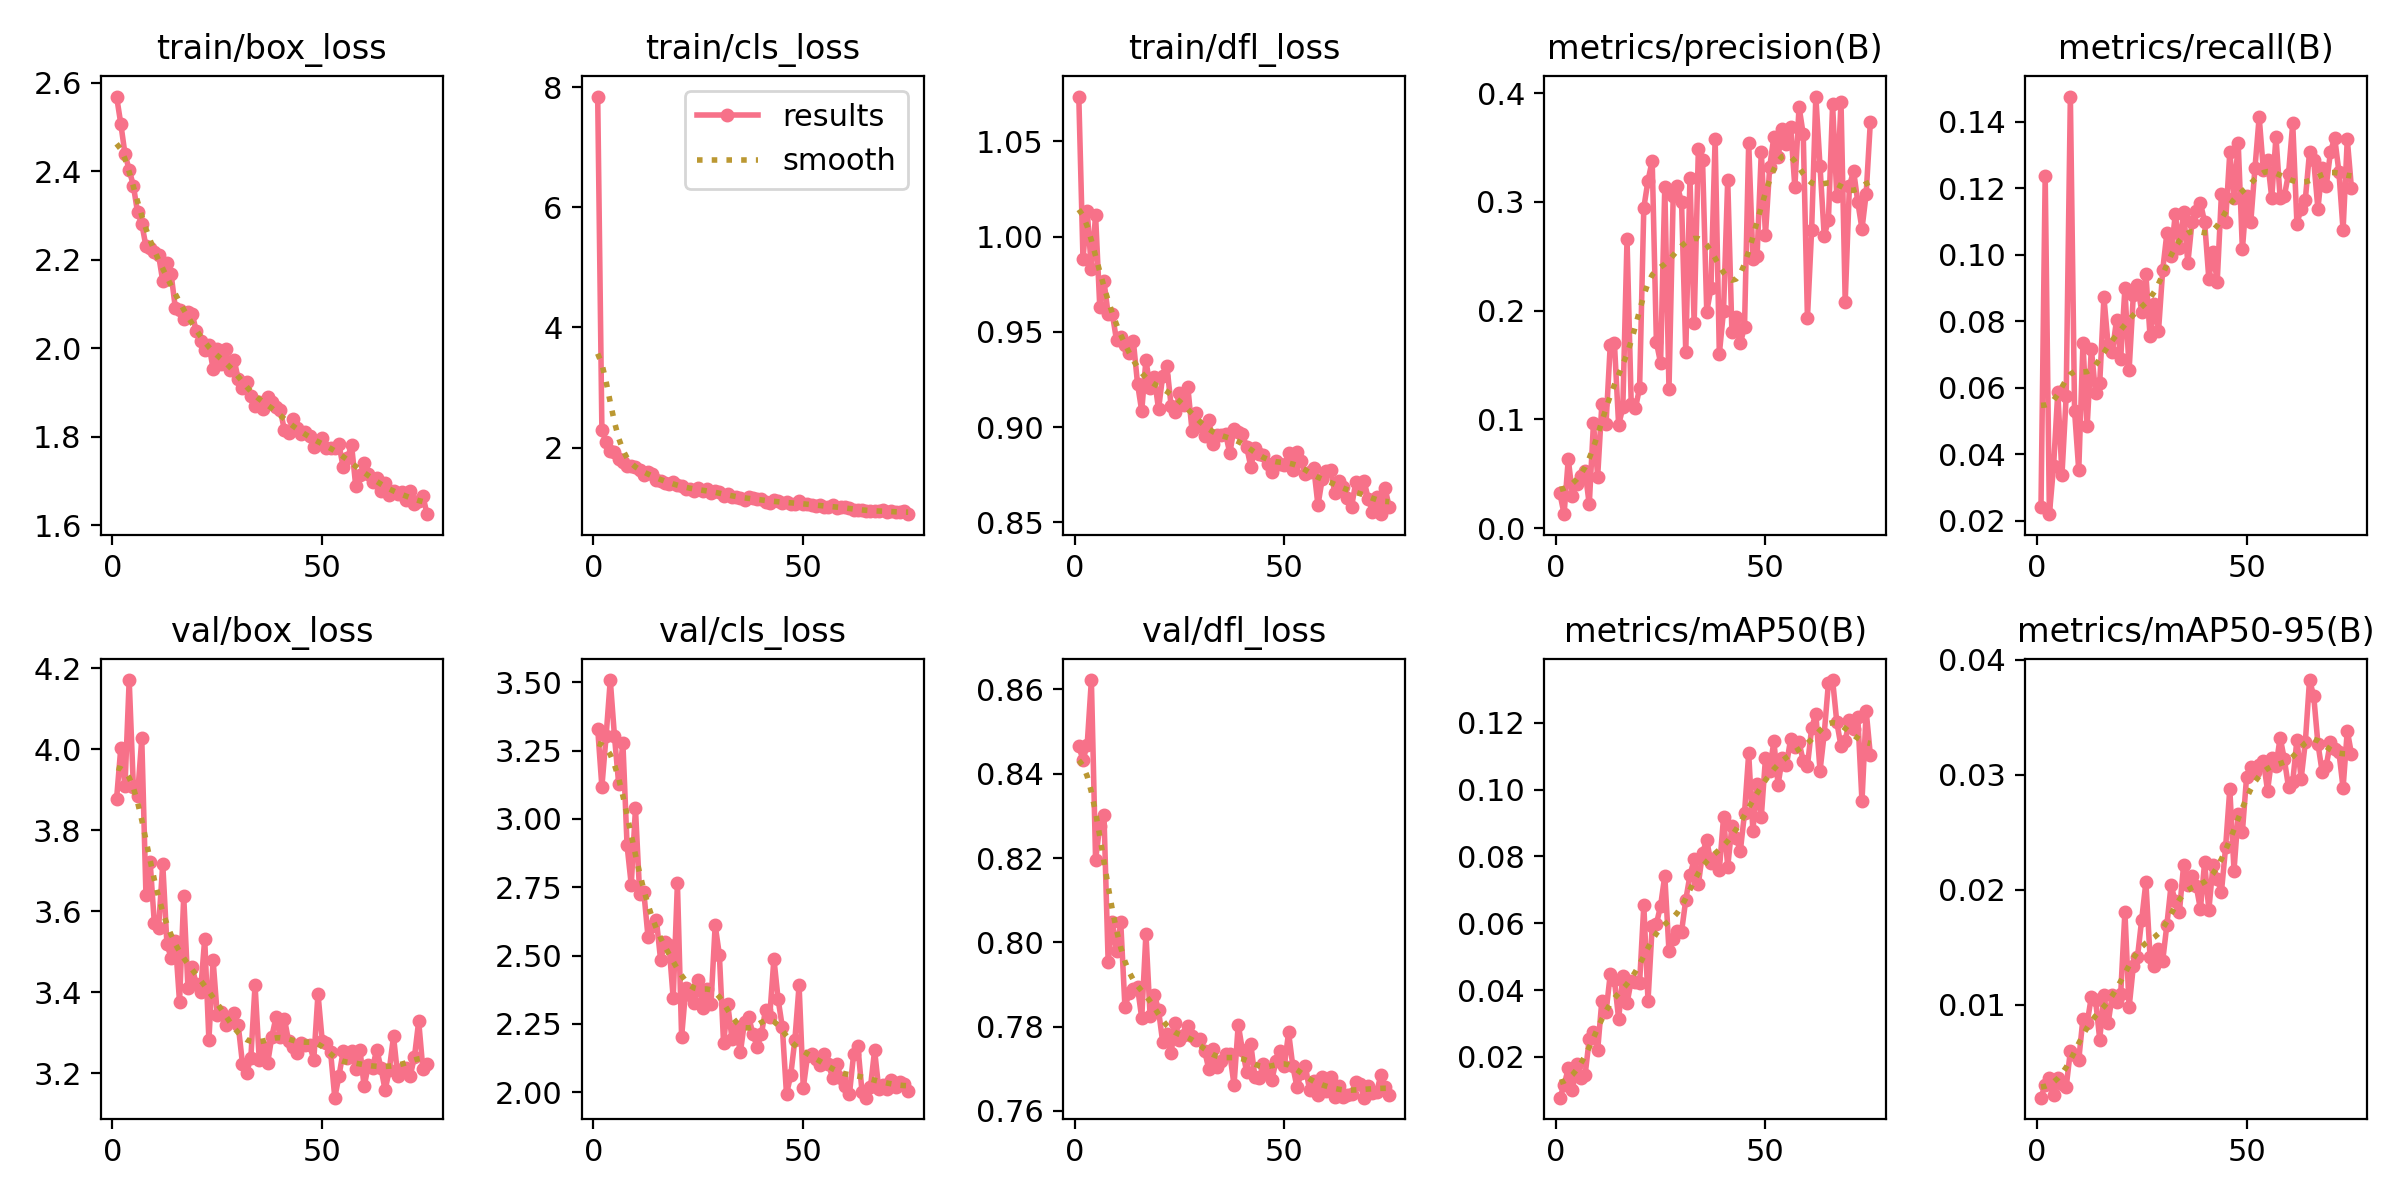

📊 Métricas de entrenamiento:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
65     66  4027.48         1.66871         0.94062         0.85791   
66     67  4087.37         1.67795         0.93932         0.87108   
67     68  4147.08         1.67038         0.93884         0.86801   
68     69  4208.04         1.67411         0.97090         0.87169   
69     70  4268.09         1.65759         0.92136         0.86224   
70     71  4326.80         1.67761         0.94896         0.85549   
71     72  4384.66         1.64914         0.92360         0.86330   
72     73  4448.73         1.65558         0.92679         0.85429   
73     74  4509.71         1.66606         0.95145         0.86785   
74     75  4569.47         1.62507         0.89322         0.85791   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
65               0.38958            0.12845           0.13280   
66               0.30520            0.11380           0.12017   
67   

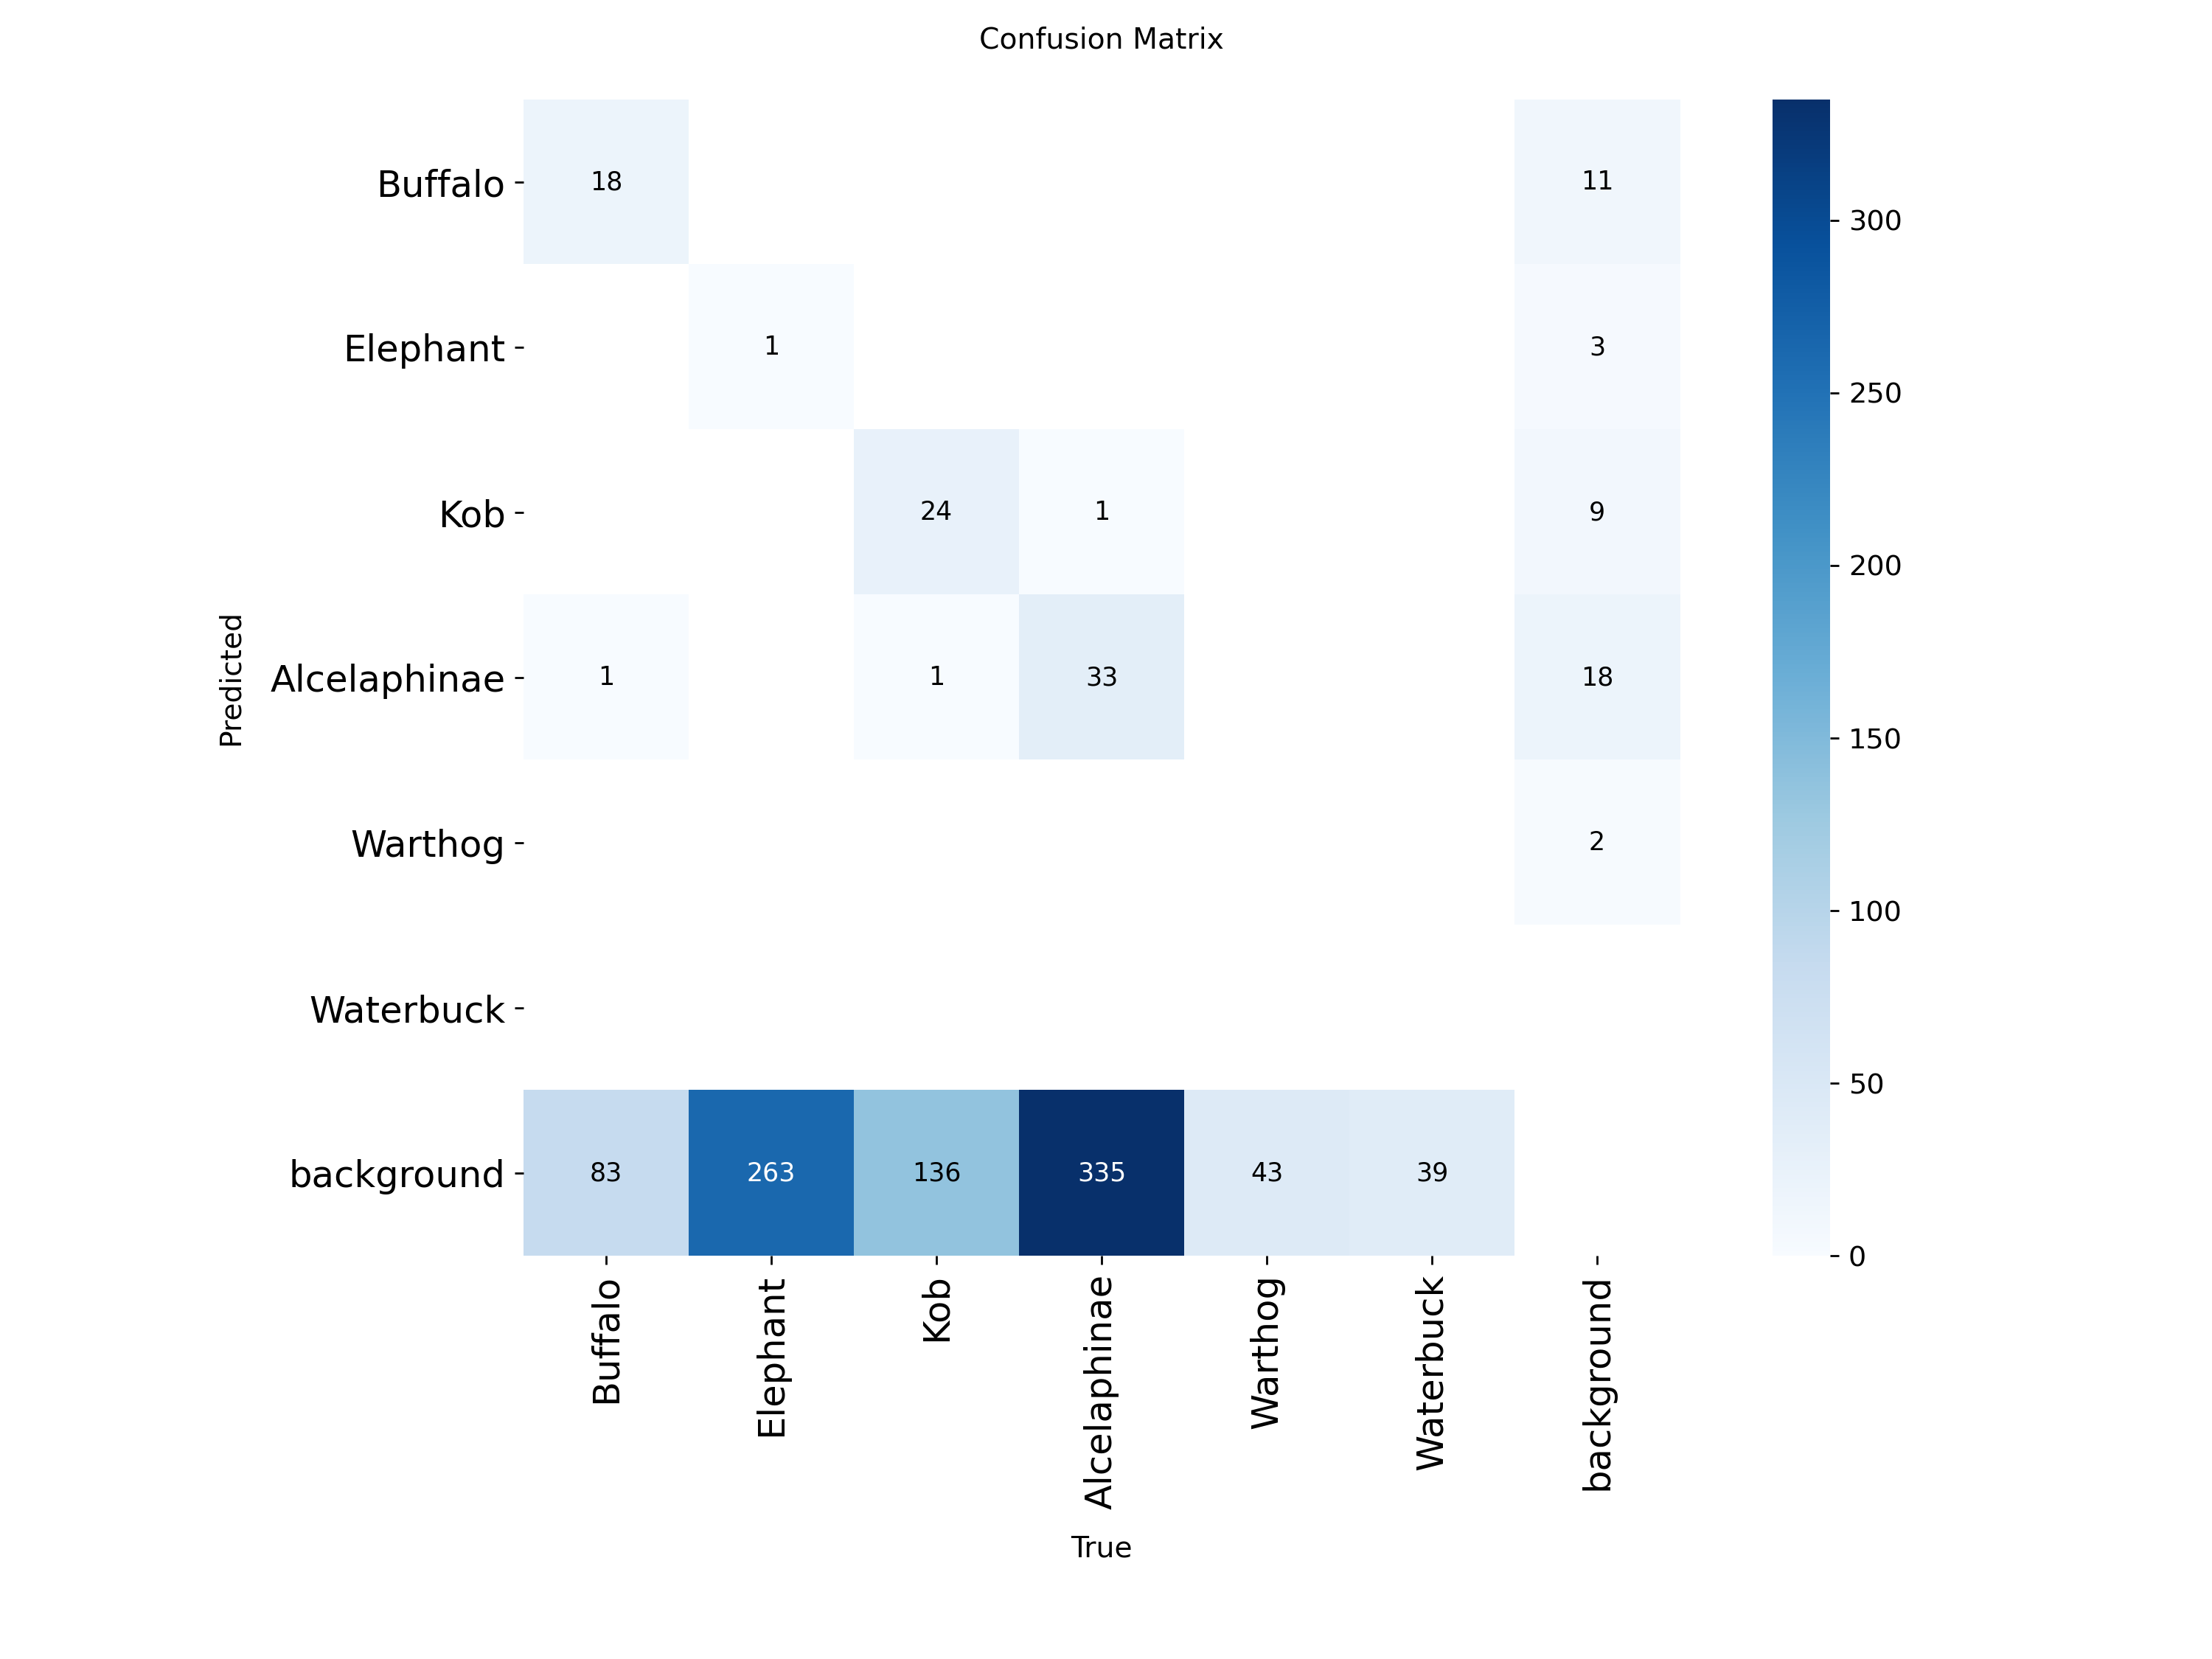

In [12]:
# Cargar el mejor modelo entrenado
best_model_path = f"{yolo_config.project}/{yolo_config.name}/weights/best.pt"
model = YOLO(best_model_path)

# Visualizar curvas de entrenamiento
results_dir = f"{yolo_config.project}/{yolo_config.name}"
if os.path.exists(f"{results_dir}/results.png"):
    display(IPImage(f"{results_dir}/results.png"))

# Mostrar métricas finales
if os.path.exists(f"{results_dir}/results.csv"):
    results_df = pd.read_csv(f"{results_dir}/results.csv")
    print("📊 Métricas de entrenamiento:")
    print(results_df.tail(10))

# Mostrar matriz de confusión
if os.path.exists(f"{results_dir}/confusion_matrix.png"):
    print("\n📊 Matriz de Confusión:")
    display(IPImage(f"{results_dir}/confusion_matrix.png"))

## 🔍 Inferencia y Pruebas

In [13]:
# Realizar inferencia en imágenes de prueba
if test_json and test_json.exists():
    # Determinar directorio de imágenes de test según el tipo de datos
    if data_type == "standard":
        test_images_dir = TEST_IMG_DIR
    elif data_type == "groundtruth":
        test_images_dir = TEST_IMG_DIR_ALT
    else:
        # Estructura legacy
        test_images_dir = test_json.parent.parent / "test"

    if test_images_dir and test_images_dir.exists():
        test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Seleccionar algunas imágenes para prueba
        sample_images = test_images[:5]  # Primeras 5 imágenes

        print(f"🔍 Realizando inferencia en {len(sample_images)} imágenes de prueba...")

        for img_name in sample_images:
            img_path = os.path.join(test_images_dir, img_name)

            # Realizar predicción
            results = model(img_path, conf=0.5)

            # Mostrar resultado
            for r in results:
                # Guardar imagen con predicciones
                output_path = f"/content/test_results_{img_name}"
                r.save(output_path)

                # Mostrar imagen
                display(IPImage(output_path))

                # Mostrar estadísticas
                print(f"📊 {img_name}: {len(r.boxes)} objetos detectados")
                if len(r.boxes) > 0:
                    for box in r.boxes:
                        class_id = int(box.cls[0])
                        confidence = float(box.conf[0])
                        class_name = yolo_config.classes[class_id]
                        print(f"  - {class_name}: {confidence:.2f}")
                print()
    else:
        print("⚠️  No se encontró directorio de imágenes de test")
else:
    print("⚠️  No hay datos de test disponibles para inferencia")

Output hidden; open in https://colab.research.google.com to view.

## 💾 Guardar y Exportar Modelo

In [14]:
# Exportar modelo a ONNX para deployment
print("🔄 Exportando modelo a ONNX...")
onnx_path = model.export(format='onnx', imgsz=yolo_config.image_size)
print(f"✅ Modelo exportado a: {onnx_path}")

# Copiar resultados a Google Drive
drive_results_dir = f"/content/drive/MyDrive/aerial-wildlife-count/results/yolov8_{yolo_config.name}"
os.makedirs(drive_results_dir, exist_ok=True)

# Copiar archivos importantes
files_to_copy = [
    f"{results_dir}/weights/best.pt",
    f"{results_dir}/weights/last.pt",
    f"{results_dir}/results.png",
    f"{results_dir}/confusion_matrix.png",
    f"{results_dir}/results.csv",
    onnx_path
]

for file_path in files_to_copy:
    if os.path.exists(file_path):
        filename = os.path.basename(file_path)
        shutil.copy2(file_path, os.path.join(drive_results_dir, filename))
        print(f"📁 Copiado: {filename}")

print(f"✅ Resultados guardados en Google Drive: {drive_results_dir}")

# Mostrar resumen final
print("\n🎉 RESUMEN DEL ENTRENAMIENTO")
print("=" * 50)
print(f"Modelo: {yolo_config.model}")
print(f"Épocas: {yolo_config.epochs}")
print(f"Tamaño de imagen: {yolo_config.image_size}")
print(f"Batch size: {yolo_config.batch_size}")
print(f"Clases: {yolo_config.classes}")
print(f"Mejor modelo: {best_model_path}")
print(f"Modelo ONNX: {onnx_path}")
print(f"Resultados en Drive: {drive_results_dir}")

🔄 Exportando modelo a ONNX...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs_yolo/yolo_aerial_wildlife_v1/weights/best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 10, 5376) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 13.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.71...
ONNX: export success ✅ 15.7s, saved as '/content/runs_yolo/yolo_aerial_wildlife_v1/weights/best.onnx' (42.6 MB)

Export complete (16.1s)
Results saved to /content/runs_yolo/yolo_aerial_wildlife_v1/weights
Predict:         yo